In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter 
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.special import ellipe
from scipy.special import ellipk

In [2]:
# Parameters for Galaxy NGC 5533
G = 4.300e-6                                                #gravitational constant (kpc/solar mass*(km/s)^2)
h = 8.9                                                     #radial scale-length (kpc)
rho00 = 0.31e9                                              #central 3D density (solar mass/kpc^2) 
epsdisk = 5.0                                               #mass-to-light ratio disk
absmag = -22.02                                             #absolute magnitude 
magsun = 4.42                                               #absolute magnitude of the sun

z0 = 0.2*h                                                  #half-thickness (kpc)
R = 4*h                                                     #cut-off radius (kpc)
d = 0.2*h                                                   #cut-off length upper limits (kpc)

print(R+d)

37.38


[1.64006981e-02 3.88501738e+00 7.87588903e+00 1.17575631e+01
 1.57546738e+01 1.96291348e+01 2.37401817e+01 2.75064980e+01
 3.13903044e+01 3.56194206e+01 3.93728638e+01 4.35945825e+01
 4.73517376e+01 5.12228289e+01 5.52093832e+01 5.94341030e+01
 6.33070897e+01 6.70612174e+01 7.11660515e+01 7.50371691e+01
 7.91434774e+01 8.31321114e+01 8.70029394e+01 9.09909416e+01]


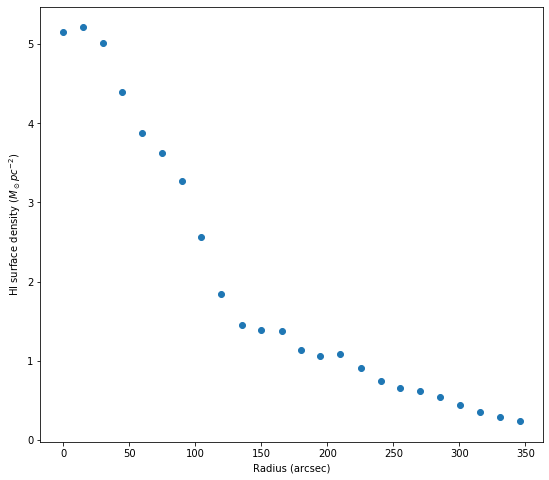

In [3]:
# H1 surface mass density data from https://www.aanda.org/articles/aa/full/2005/40/aa3172-05/aa3172-05_online.html
# Used DataThief to get data from image
h1data = np.loadtxt("../5533_h1_data/h1data.txt")
rarcsec, h1smd = h1data.T

# Converting arcseconds to kpc for radius measurements
D = 54.3         # in Mpc
rkpc = rarcsec*D*1000/206265                # calculated using http://astro.physics.uiowa.edu/ITU/glossary/small-angle-formula/
print(rkpc)

# Plot HI surface density
plt.figure(figsize=(9,8))
plt.scatter(rarcsec,h1smd)
plt.xlabel("Radius (arcsec)")
plt.ylabel("HI surface density ($M_\odot pc^{-2}$)")
plt.show()

# Does this measured H1 data equal rho00?
rho00 = inter.UnivariateSpline(rkpc, h1smd, k=3)

In [4]:
#definitions
def x(r,u,z):
    return ((r**2)+(u**2)+(z**2))/(2*r*u)

def px(r,u,z):
    return x(r,u,z)-(np.sqrt((x(r,u,z)**2)-1))

In [5]:
#density piecewise function
def rho0(r,R,h,d):
    condlist = [r <= R, (r > R) & (r <= (R+d)), r > (R+d)]
    funclist = [lambda r: rho00(r)*np.exp(-r/h), lambda r: rho00(r)*np.exp(-R/h)*(1-(r-R)/d), lambda r: 0]
    return np.piecewise(r, condlist, funclist)
#print(rho0(37,R,h,d))
#print(rho0(38,R,h,d))

In [6]:
#partial derivative of rho(xi,u)
def durho0(r,R,h,d):
    condlist = [r <= R, (r > R) & (r <= (R+d)), r > (R+d)]
    funclist = [lambda r: -(1/h)*rho00(r)*np.exp(-r/h), lambda r: -(1/d)*rho00(r)*np.exp(-R/h), lambda r: 0]
    return np.piecewise(r, condlist, funclist)
#print(durho0(37,R,h,d))
#print(durho0(38,R,h,d))

In [7]:
#disk density distribution
def rho_rz(r,z):
    rho_rz = rho0(r,R,h,d)*(np.power(np.cosh(z/z0), (-2)))
    return rho_rz

def drho_rz(r,z):
    drho_rz = durho0(r,R,h,d)*(np.power(np.cosh(z/z0), (-2)))
    return drho_rz

In [8]:
#complete elliptic integral
def K(r,u,z):
    K = ellipk(px(r,u,z)) - ellipe(px(r,u,z))
    return K

In [9]:
#inner function
def innerf(r,u,z): 
    innerf = u*drho_rz(u,z)*(2*K(r,u,z))/(np.pi*np.sqrt(r*u*px(r,u,z)))
    return innerf

In [10]:
#integrate function
def innerf2(z,r,u):
    innerf2 = innerf(r,u,z)
    return innerf2

intinnerf = lambda u,r: quad(innerf2, 0, np.inf, args=(r,u,))[0]

In [11]:
#integrate outer function
def intinnerf2(u,r): 
    intinnerf2 = intinnerf(r,u)
    return intinnerf2

intouterf = lambda r: quad(intinnerf2, 0, np.inf, args=(r,))[0]

In [12]:
#Radial force
F = lambda r: 4*np.pi*G*intouterf(r)

In [13]:
#disk velocity
rd = np.linspace(0.1, 1000, num=500)
Fv = np.vectorize(F)
v = np.sqrt(-rd*Fv(rd))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the posi

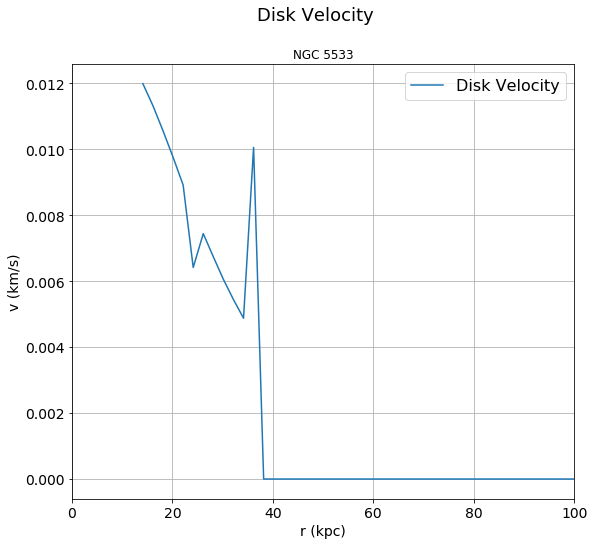

In [14]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.plot(rd, v, linestyle='solid', label='Disk Velocity')

plt.axis('tight');

fig.suptitle('Disk Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,100)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()